In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten
from tensorflow.keras.regularizers import l2
import re

In [2]:
data = pd.read_csv('../raw_data/new_df_clean2.csv')
data

,title,text,label,total
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1.0,941
1,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0.0,1290
2,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1.0,329
3,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1.0,255
4,Sports Bar Owner Bans NFL Games‚Ä¶Will Show On...,"The owner of the Ringling Bar, located south o...",1.0,270
...,...,...,...,...
56376,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0.0,746
56377,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1.0,612
56378,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0.0,466
56379,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump‚Äôs comba...,0.0,565


In [6]:
# remove duplicate items
data.drop_duplicates(inplace=True)
data.shape

(56076, 4)

In [7]:
# check for null values
data.isnull().sum()

title    0
text     0
label    0
total    0
dtype: int64

In [8]:
# use regex to remove the unimportant info at the begining of each row ('CITY NAME (Reuteurs) -')
def remove_city_name(text):
    pattern = r'(?:[A-Z]+(?:[ \/][A-Z]+)* )?\(Reuters\) - '
    return re.sub(pattern, '', text)

In [9]:
data = data.drop(columns=['title', 'total'])

In [13]:
# apply regex funciton to each row of the df
data['text'] = data['text'].apply(remove_city_name)
data.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1.0
1,A dozen politically active pastors came here f...,0.0
2,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1.0
3,All we can say on this one is it s about time ...,1.0
4,"The owner of the Ringling Bar, located south o...",1.0


In [14]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [15]:
data['text_clean'] = data['text'].apply(cleaning)
data

,text,label,text_clean
0,No comment is expected from Barack Obama Membe...,1.0,comment expect barack obama members fyf fukyof...
1,A dozen politically active pastors came here f...,0.0,dozen politically active pastors come private ...
2,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1.0,rs sarmat missile dub satan replace ss fly mil...
3,All we can say on this one is it s about time ...,1.0,say one time someone sue southern poverty law ...
4,"The owner of the Ringling Bar, located south o...",1.0,owner ringling bar locate south white sulphur ...
...,...,...,...
56374,An email released by WikiLeaks on Sunday appea...,1.0,email release wikileaks sunday appear show for...
56376,Hackers believed to be working for the Russian...,0.0,hackers believe work russian government break ...
56377,"You know, because in fantasyland Republicans n...",1.0,know fantasyland republicans never question ci...
56378,Migrants Refuse To Leave Train At Refugee Camp...,0.0,migrants refuse leave train refugee camp hunga...


In [16]:
X = data.text_clean
y = data.label

In [17]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [19]:
# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [21]:
sequences = tokenizer.texts_to_sequences(data.text_clean)

lengths_of_texts =  [len(text) for text in sequences]

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_sequences, maxlen=avg_length_text, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_sequences, maxlen=avg_length_text, padding='pre')
X_test_pad = pad_sequences(X_test_sequences, maxlen=avg_length_text, padding='post', truncating='post')

In [46]:
%%time
from keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8, 
             input_length=avg_length_text), ## recall that we set the post-padding length to be this value 
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER 
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics 
model_rnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=1000, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/1000
1227/1227 [==============================] - 162s 131ms/step - loss: 0.6760 - accuracy: 0.5590 - val_loss: 0.6800 - val_accuracy: 0.5486
Epoch 2/1000
1227/1227 [==============================] - 166s 135ms/step - loss: 0.6339 - accuracy: 0.5876 - val_loss: 0.5205 - val_accuracy: 0.7622
Epoch 3/1000
1227/1227 [==============================] - 169s 137ms/step - loss: 0.5280 - accuracy: 0.7258 - val_loss: 0.3430 - val_accuracy: 0.8714
Epoch 4/1000
1227/1227 [==============================] - 180s 147ms/step - loss: 0.4894 - accuracy: 0.7763 - val_loss: 0.5032 - val_accuracy: 0.7424
Epoch 5/1000
1227/1227 [==============================] - 175s 142ms/step - loss: 0.4005 - accuracy: 0.8410 - val_loss: 0.4316 - val_accuracy: 0.8412
Epoch 6/1000
1227/1227 [==============================] - 185s 151ms/step - loss: 0.4124 - accuracy: 0.8376 - val_loss: 0.5028 - val_accuracy: 0.8036
Epoch 7/1000
1227/1227 [==============================] - 187s 152ms/step - loss: 0.4177 - accuracy:

In [47]:
# Evaluate the model on the test set
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)

263/263 [==============================] - 3s 10ms/step - loss: 0.3689 - accuracy: 0.8726


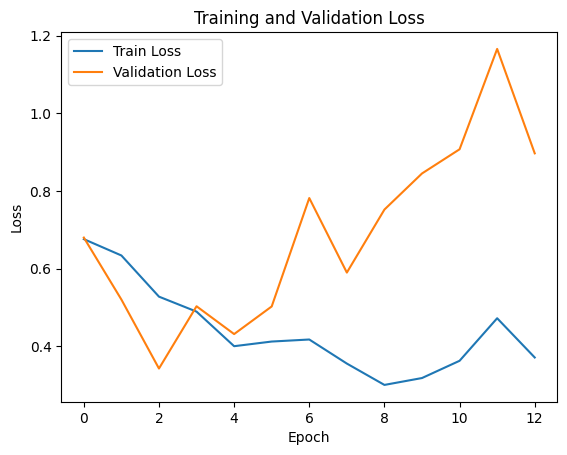

In [48]:
# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

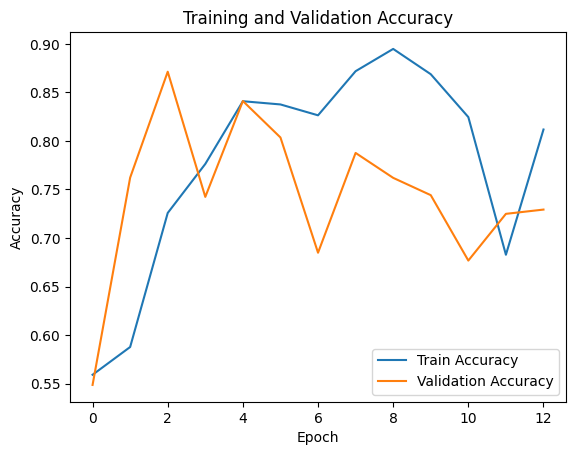

In [49]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
y_pred = model_rnn.predict(X_test_pad)

263/263 [==============================] - 3s 10ms/step


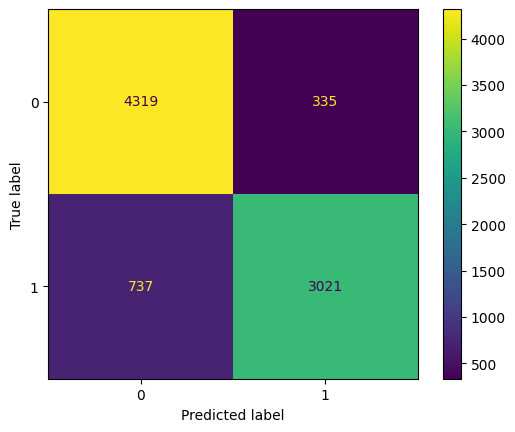

In [51]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf

predicted = tf.squeeze(y_pred)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [30]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""


In [31]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday 
that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being 
honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [32]:
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## download the dictionary for stopwords
nltk.download('stopwords')

## get the set of stopwords 
stop_words_set = set(stopwords.words('english'))

## Load English tokenizer from spacy
nlp = English()
spacy_tokenizer = nlp.tokenizer ## make instance 

## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
    result = []
    
    # Tokenize using spaCy's tokenizer
    for text in texts:
        tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        result.append(" ".join(tokens))
    
    return result

[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
bbc_cleaned = optimized_preprocess([bbc_snippet])
theonion_cleaned = optimized_preprocess([theonion_snippet])


In [34]:
bbc_seq = tokenizer.texts_to_sequences(bbc_cleaned)
theonion_seq = tokenizer.texts_to_sequences(theonion_cleaned)


In [35]:
bbc_pad = pad_sequences(bbc_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')
theonion_pad = pad_sequences(theonion_seq, maxlen=  avg_length_text, padding = 'post', truncating = 'post')

In [36]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))


1/1 [==============================] - 0s 33ms/step
[[0.9081968]]
1/1 [==============================] - 0s 32ms/step
[[0.9081968]]
